In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import time
from datetime import datetime
from sklearnex import patch_sklearn
patch_sklearn()
from hpsklearn import *
from hyperopt import hp, tpe

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
SEED = 10
limit_rows = (1)*1000

In [3]:
print(f"Execution started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution started at 2022-03-01 19:39:29.


In [4]:
def load_csv(name):
    if limit_rows is None:
        return pd.read_table(filepath_or_buffer=f'../Data Preprocessing/sklearn/iot23_combined_{name}.csv', sep=',').infer_objects()
    else:
        return pd.read_table(filepath_or_buffer=f'../Data Preprocessing/sklearn/iot23_combined_{int(limit_rows/1000)}k_{name}.csv', sep=',').infer_objects()

In [5]:
X_train, X_test, y_train, y_test = load_csv('X_train'), load_csv('X_test'), load_csv('y_train'), load_csv('y_test')

print('X_train',X_train.shape,'\ny_train',y_train.shape)

print('X_test',X_test.shape,'\ny_test',y_test.shape)

X_train (7713, 16) 
y_train (7713, 1)
X_test (1928, 16) 
y_test (1928, 1)


In [6]:
X_train

,0.595344,0.906291,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,1,0.8,1.1,0.9,0.10,0.11
0,0.524791,0.000763,0.000462,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,0,1,0,0,0.0
1,0.752627,0.101802,0.000312,0.000003,0.000021,0.0,0.000001,0.000001,0.000869,0.000051,1,0,0,1,0,0.0
2,0.917425,0.000809,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,1,1,0,0,0.0
3,0.001833,0.001878,0.000001,0.000004,0.000008,0.0,0.000000,0.000000,0.000248,0.000013,0,1,0,0,1,0.0
4,0.001833,0.001878,0.000003,0.000002,0.000004,0.0,0.000000,0.000000,0.000124,0.000006,0,1,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7708,0.915547,0.001222,0.000464,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,0,1,0,0,0.0
7709,0.777876,0.000336,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,0,1,0,0,0.0
7710,0.368974,0.123393,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,0,1,0,0,0.0
7711,0.777891,0.075966,0.000149,0.000002,0.000011,0.0,0.000000,0.000001,0.000497,0.000027,1,0,0,0,0,0.0


In [7]:
def build_clf_name(clf):
    clf_name = clf.name.replace('sklearn_','').replace('Classifier','')
    if clf_name == 'switch':
        clf_name = 'SVC-LL'
    elif 'SVC' in clf_name:
        for arg in clf.named_args:
            if arg[0] == 'kernel':
                clf_name += f'-{arg[1].obj.capitalize()[0]}'
    clf_name = ''.join(c for c in clf_name if (c.isupper() or c == '-'))
    return clf_name

In [8]:
classifiers = [
    ada_boost('ab'),
    decision_tree('dt'),
    extra_trees('et'),
    gaussian_nb('gnb'),
    gradient_boosting('gb'),
    knn('knn'),
    liblinear_svc('svc-ll'),
    linear_discriminant_analysis('lda',n_components=1),
    multinomial_nb('mnb'),
    one_vs_one('ovo'),
    one_vs_rest('ovr'),
    output_code('oc'),
    passive_aggressive('pa'),
    quadratic_discriminant_analysis('qda'),
    random_forest('rf'),
    sgd('sgd'),
    svc('svc'),
    svc_linear('svc-l'),
    svc_poly('svc-p'),
    svc_rbf('svc-r'),
    svc_sigmoid('svc-s'),
    xgboost_classification('xgb')
]

In [9]:
best_results = {}

for clf in classifiers:
    
    clf_name = build_clf_name(clf)
    
    print(f'\n******************** {clf_name} ********************')
    
    best_results[clf_name] = (0.0, None)
        
    try:
        estim = HyperoptEstimator(classifier=clf,
                                  preprocessing=[],
                                  algo=tpe.suggest,
                                  max_evals=3,
                                  trial_timeout=60,
                                  seed=np.random.default_rng(SEED),
                                  fit_increment=1,
                                  fit_increment_dump_filename=f'hyperopt_increments/{clf_name}.inc',
                                  n_jobs=1)
    except Exception as e:
        print(f"********** Could not create {clf_name}. Reason: '{str(e)}'. **********")
        
    try:
        estim.fit(X_train, y_train, random_state=SEED)
    except Exception as e:
        print(f"********** Could not fit {clf_name}. Reason: '{str(e)}'. **********")
        
    try:
        score = estim.score(X_test, y_test)
        best_model = estim.best_model()
        best_results[clf_name] = (score, best_model)
        print(best_results[clf_name])
    except Exception as e:
        print(f"********** Could not evaluate {clf_name}. Reason: '{str(e)}'. **********")


******************** AB ********************
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  3.00s/trial, best loss: 0.025275437459494454]


C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9725103734439834, {'learner': AdaBoostClassifier(algorithm='SAMME', learning_rate=0.3756144655926187,
                   n_estimators=483, random_state=4), 'preprocs': (), 'ex_preprocs': ()})

******************** DT ********************
100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  1.17trial/s, best loss: 0.01944264419961117]
(0.9859958506224067, {'learner': DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=9, random_state=1,
                       splitter='random'), 'preprocs': (), 'ex_preprocs': ()})

******************** ET ********************
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  3.15s/trial, best loss: 0.022034996759559333]


C:\Users\marce\anaconda3\envs\tf\lib\site-packages\hpsklearn\estimator.py:746: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._best_learner.fit(XEX, y)


(0.9808091286307054, {'learner': ExtraTreesClassifier(bootstrap=True, max_features=None, n_estimators=1195,
                     n_jobs=1, random_state=4, verbose=False), 'preprocs': (), 'ex_preprocs': ()})

******************** GNB ********************
100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  1.07trial/s, best loss: 0.2754374594944913]
(0.7531120331950207, {'learner': GaussianNB(), 'preprocs': (), 'ex_preprocs': ()})

******************** GB ********************
  0%|                                                                                                                 | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 50%|████████████████████████████████████████████████████████▌                                                        | 1/2 [00:00<?, ?trial/s, best loss=?]

job exception: ExponentialLoss requires 2 classes; got 3 class(es)



 50%|████████████████████████████████████████████████████████▌                                                        | 1/2 [00:00<?, ?trial/s, best loss=?]
********** Could not fit GB. Reason: 'ExponentialLoss requires 2 classes; got 3 class(es)'. **********
********** Could not evaluate GB. Reason: 'This GradientBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.'. **********

******************** KN ********************
100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  3.32s/trial, best loss: 0.11211924821775765]


C:\Users\marce\anaconda3\envs\tf\lib\site-packages\daal4py\sklearn\neighbors\_base.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)


(0.8807053941908713, {'learner': KNeighborsClassifier(n_jobs=1, n_neighbors=24, p=3.0, weights='distance'), 'preprocs': (), 'ex_preprocs': ()})

******************** LSVC ********************
100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:51<00:00, 51.79s/trial, best loss: 0.26636422553467276]


C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.491701244813278, {'learner': LinearSVC(C=48617.228800553676, class_weight='balanced', dual=False,
          intercept_scaling=0.41034553377344246, multi_class='crammer_singer',
          random_state=0, tol=0.00011321032970961408, verbose=False), 'preprocs': (), 'ex_preprocs': ()})

******************** LDA ********************
  0%|                                                                                                                 | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  1.03trial/s, best loss: 0.2696046662346079]
(0.7593360995850622, {'learner': LinearDiscriminantAnalysis(n_components=1, shrinkage='auto', solver='eigen',
                           tol=1e-05), 'preprocs': (), 'ex_preprocs': ()})

******************** MNB ********************
  0%|                                                                                                                 | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.11s/trial, best loss: 0.27738172391445237]
(0.754149377593361, {'learner': MultinomialNB(alpha=0.38), 'preprocs': (), 'ex_preprocs': ()})

******************** OVO ********************
  0%|                                                                                                                 | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.08s/trial, best loss: 0.02657161373946859]


C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.983402489626556, {'learner': OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.011641046969577998,
                                                        max_depth=None,
                                                        max_features=0.4941456118168194,
                                                        min_samples_leaf=7,
                                                        n_estimators=48,
                                                        random_state=4,
                                                        subsample=0.93482899929673),
                   n_jobs=1), 'preprocs': (), 'ex_preprocs': ()})

******************** OVR ********************
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.08s/trial, best loss: 0.025275437459494454]
(0.9818464730290456, {'learner': OneVsRestClassifier(estimator=GradientBoostingClassifier(learning_rate=0.011641046969577998,
             

C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9144190871369294, {'learner': OutputCodeClassifier(estimator=GradientBoostingClassifier(learning_rate=0.011641046969577998,
                                                          max_depth=None,
                                                          max_features=0.4941456118168194,
                                                          min_samples_leaf=7,
                                                          n_estimators=48,
                                                          random_state=4,
                                                          subsample=0.93482899929673),
                     n_jobs=1), 'preprocs': (), 'ex_preprocs': ()})

******************** PA ********************
100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  1.10trial/s, best loss: 0.27219701879455604]
(0.7557053941908713, {'learner': PassiveAggressiveClassifier(C=0.10580618144023571, fit_intercept=False,
                  

C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  1.05trial/s, best loss: 0.27738172391445237]
(0.754149377593361, {'learner': QuadraticDiscriminantAnalysis(reg_param=0.3512953517399541), 'preprocs': (), 'ex_preprocs': ()})

******************** RF ********************
  0%|                                                                                                                 | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  2.07s/trial, best loss: 0.02268308489954629]
(0.9828838174273858, {'learner': RandomForestClassifier(criterion='entropy', max_features=0.2531954371648645,
                       min_samples_leaf=2, n_estimators=37, n_jobs=1,
                       random_state=4, verbose=False), 'preprocs': (), 'ex_preprocs': ()})

******************** SGD ********************
  0%|                                                                                                                 | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\marce\anaconda3\envs\tf\lib\site-packages\daal4py\sklearn\ensemble\_forest.py:350: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return super(RandomForestClassifier, self).fit(


100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.02s/trial, best loss: 0.2670123136746597]
(0.7624481327800829, {'learner': SGDClassifier(alpha=0.0006379623179663057, class_weight='balanced',
              eta0=0.00011422166980413974, l1_ratio=0.46788713954999506,
              loss='log', max_iter=14829567.0, n_jobs=1, penalty='elasticnet',
              power_t=0.7226192697361069, random_state=0,
              tol=0.00011321032970961408, verbose=False), 'preprocs': (), 'ex_preprocs': ()})

******************** SVC-LL ********************
  0%|                                                                                                                 | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.79s/trial, best loss: 0.1827608554763448]


C:\Users\marce\anaconda3\envs\tf\lib\site-packages\onedal\datatypes\validation.py:126: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = _column_or_1d(y, warn=True)


(0.8200207468879668, {'learner': SVC(C=37.342663628925735, cache_size=512, coef0=-1.3999003460080859, degree=1,
    gamma=0.3343325358844833, kernel='sigmoid', max_iter=46047080.0,
    random_state=3, tol=0.00013835805102197597), 'preprocs': (), 'ex_preprocs': ()})

******************** SVC-L ********************
100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56s/trial, best loss: 0.2670123136746597]


C:\Users\marce\anaconda3\envs\tf\lib\site-packages\onedal\datatypes\validation.py:126: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = _column_or_1d(y, warn=True)


(0.7624481327800829, {'learner': SVC(C=0.44715364630050225, cache_size=512, degree=1, gamma='auto',
    kernel='linear', max_iter=19440826.0, random_state=1,
    tol=0.003292008207495153), 'preprocs': (), 'ex_preprocs': ()})

******************** SVC-P ********************
  0%|                                                                                                                 | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


  0%|                                                                                                                 | 0/1 [00:01<?, ?trial/s, best loss=?]
********** Could not fit SVC-P. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********
********** Could not evaluate SVC-P. Reason: 'Attempting to use a model that has not been fit. Ensure fit() has been called and at least one trial has completed without failing or timing out.'. **********

******************** SVC-R ********************
100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 60.89s/trial, best loss: 0.26636422553467276]


C:\Users\marce\anaconda3\envs\tf\lib\site-packages\onedal\datatypes\validation.py:126: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = _column_or_1d(y, warn=True)


(0.7531120331950207, {'learner': SVC(C=19.21572171058445, cache_size=512, degree=1, gamma=0.09763516860628368,
    max_iter=548676042.0, random_state=1, tol=0.003799057710504326), 'preprocs': (), 'ex_preprocs': ()})

******************** SVC-S ********************
100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58s/trial, best loss: 0.3091380427738173]


C:\Users\marce\anaconda3\envs\tf\lib\site-packages\onedal\datatypes\validation.py:126: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = _column_or_1d(y, warn=True)


(0.7256224066390041, {'learner': SVC(C=0.003403724272190324, cache_size=512, coef0=0.2935898951799667, degree=1,
    gamma=0.2676077838782693, kernel='sigmoid', max_iter=19440826.0,
    random_state=1, tol=0.003292008207495153), 'preprocs': (), 'ex_preprocs': ()})

******************** XGB ********************
  0%|                                                                                                                 | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: No module named xgboost


  0%|                                                                                                                 | 0/1 [00:00<?, ?trial/s, best loss=?]
********** Could not fit XGB. Reason: 'No module named xgboost'. **********
********** Could not evaluate XGB. Reason: 'Attempting to use a model that has not been fit. Ensure fit() has been called and at least one trial has completed without failing or timing out.'. **********


In [10]:
best_results = dict(sorted(best_results.items()))
print(json.dumps(best_results, indent=4, default=str))

{
    "AB": [
        0.9725103734439834,
        {
            "learner": "AdaBoostClassifier(algorithm='SAMME', learning_rate=0.3756144655926187,\n                   n_estimators=483, random_state=4)",
            "preprocs": [],
            "ex_preprocs": []
        }
    ],
    "DT": [
        0.9859958506224067,
        {
            "learner": "DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=9, random_state=1,\n                       splitter='random')",
            "preprocs": [],
            "ex_preprocs": []
        }
    ],
    "ET": [
        0.9808091286307054,
        {
            "learner": "ExtraTreesClassifier(bootstrap=True, max_features=None, n_estimators=1195,\n                     n_jobs=1, random_state=4, verbose=False)",
            "preprocs": [],
            "ex_preprocs": []
        }
    ],
    "GB": [
        0.0,
        null
    ],
    "GNB": [
        0.7531120331950207,
        {
            "learner": "GaussianNB()",
            "preprocs":

['AB', 'DT', 'ET', 'GB', 'GNB', 'KN', 'LDA', 'LSVC', 'MNB', 'OC', 'OVO', 'OVR', 'PA', 'QDA', 'RF', 'SGD', 'SVC-L', 'SVC-LL', 'SVC-P', 'SVC-R', 'SVC-S', 'XGB']
[0.9725103734439834, 0.9859958506224067, 0.9808091286307054, 0.0, 0.7531120331950207, 0.8807053941908713, 0.7593360995850622, 0.491701244813278, 0.754149377593361, 0.9144190871369294, 0.983402489626556, 0.9818464730290456, 0.7557053941908713, 0.754149377593361, 0.9828838174273858, 0.7624481327800829, 0.7624481327800829, 0.8200207468879668, 0.0, 0.7531120331950207, 0.7256224066390041, 0.0]


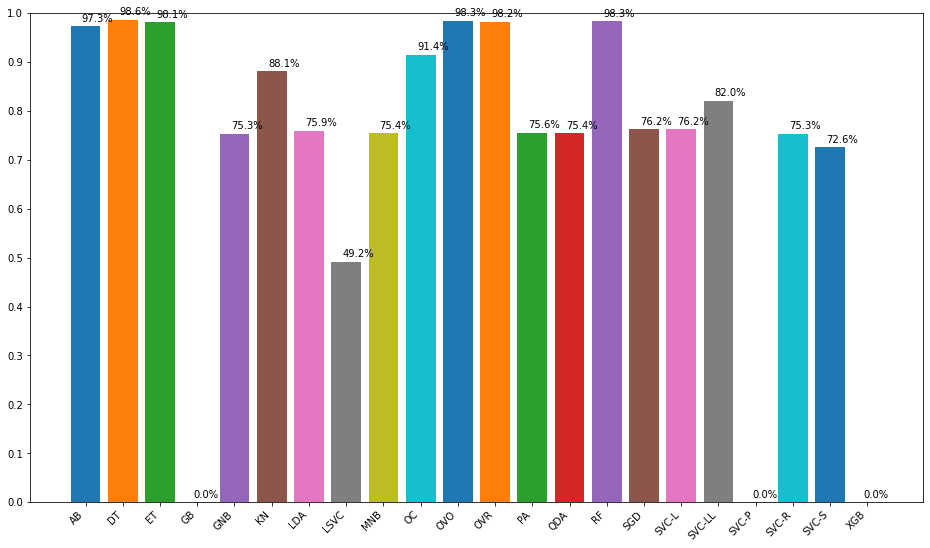

In [11]:
names = list(best_results.keys())
print(names)
values = list(x[0] for x in best_results.values())
print(values)

plt.figure(figsize=(16,9))
idx = 0
for i in range(len(best_results.keys())):
    plt.bar(names[i],values[i])
    plt.text(idx-0.1,values[i]+0.01,f'{100*values[i]:.1f}%')
    idx += 1
plt.xticks(rotation=45, ha='right')
plt.xticks(range(0,len(best_results)),names)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.show()

In [12]:
print(f"Execution finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution finished at 2022-03-01 19:44:06.
